<a href="https://colab.research.google.com/github/Arwin-K/Fake-News-Detection/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing Libraries**

In [24]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for Traditional ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

# Deep Learning (Transformers)
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# NLTK Resources
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Set Seed for Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Importing dataset through Kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle datasets download -d aadyasingh55/fake-news-classification

# Unzip the downloaded file
!unzip fake-news-classification.zip

#**Importing and Standardizing Kaggle Dataset**

In [5]:
# Loading the training set
train_df = pd.read_csv('train (2).csv', sep=';')

# Loading the test set
test_df = pd.read_csv('test (1).csv', sep=';')

# Loading the evaluation set
eval_df = pd.read_csv('evaluation.csv', sep=';')

In [6]:
# Renaming files for easier naming system convention
import os
os.rename('train (2).csv', 'fake_news_detection_train.csv')
os.rename('test (1).csv', 'fake_news_detection_test.csv')
os.rename('evaluation.csv', 'fake_news_detection_evaluation.csv')

In [7]:
# Printing dataset sizes and head columns
print(f"Training Dataset Shape: {train_df.shape}")
train_df.head()

print(f"Testing Dataset Shape: {test_df.shape}")
test_df.head()

print(f"Evaluation Dataset Shape: {eval_df.shape}")
eval_df.head()

Training Dataset Shape: (24353, 4)
Testing Dataset Shape: (8117, 4)
Evaluation Dataset Shape: (8117, 4)


,Unnamed: 0,title,text,label
0,0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1
1,1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1
2,2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0
3,3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0
4,4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0


# **Applying Traditional Machine Learning Models**

**Preprocessing**

In [8]:
# Creating a clean text column within each dataset for the model to use
train_df['content'] = train_df['title'].astype(str) + " " + train_df['text'].astype(str)
test_df['content'] = test_df['title'].astype(str) + " " + test_df['text'].astype(str)
eval_df['content'] = eval_df['title'].astype(str) + " " + eval_df['text'].astype(str)

# Check if column has been added
print(train_df.columns)
print(test_df.columns)
print(eval_df.columns)

Index(['Unnamed: 0', 'title', 'text', 'label', 'content'], dtype='object')
Index(['Unnamed: 0', 'title', 'text', 'label', 'content'], dtype='object')
Index(['Unnamed: 0', 'title', 'text', 'label', 'content'], dtype='object')


In [9]:
lemmatizer = WordNetLemmatizer() # Built in lemmatizer
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text) # Ensure string
    # 1. Lowercasing
    text = text.lower()

    # 2. Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # 3. Tokenization & Stopword Removal & Lemmatization
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(words)

# Apply preprocessing
print("Preprocessing training data...")
train_df['clean_text'] = train_df['content'].apply(preprocess_text)
print("Preprocessing test data...")
test_df['clean_text'] = test_df['content'].apply(preprocess_text)
print("Preprocessing evaluation data...")
eval_df['clean_text'] = eval_df['content'].apply(preprocess_text)

print("Preprocessing complete.")

Preprocessing training data...
Preprocessing test data...
Preprocessing evaluation data...
Preprocessing complete.


**Setting up TF-IDF Vectorizer**

In [10]:
tfidf = TfidfVectorizer(max_features=5000) # Can adjust for memory size

# Generating train and testing vectors
x_train_vec = tfidf.fit_transform(train_df['clean_text'])
x_test_vec = tfidf.transform(test_df['clean_text'])

y_train = train_df['label']
y_test = test_df['label']

**Creating ML models**

In [11]:
# Creating traditional Machne Learning models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Support Vector Machine": SVC(kernel='linear')
}

**Training and Testing**

In [12]:
results = {}

for name, model in models.items():

  # Training each model individially
  model.fit(x_train_vec, y_train)
  print(f"Training {name} model")

  # Generating predictions with test set
  y_pred = model.predict(x_test_vec)

  # Evaluating the models accuracy, precision, recall and F1 score
  results[name] = {
      "Accuracy": accuracy_score(y_test, y_pred),
      "Precision": precision_score(y_test, y_pred, average = 'weighted'),
      "Recall": recall_score(y_test, y_pred, average = 'weighted'),
      "F1 Score": f1_score(y_test, y_pred, average = 'weighted')
  }

  print(f"Completed: {name}\n")

Training Logistic Regression model
Completed: Logistic Regression

Training Naive Bayes model
Completed: Naive Bayes

Training Random Forest model
Completed: Random Forest

Training Support Vector Machine model
Completed: Support Vector Machine



**Displaying the Results of the Testing**

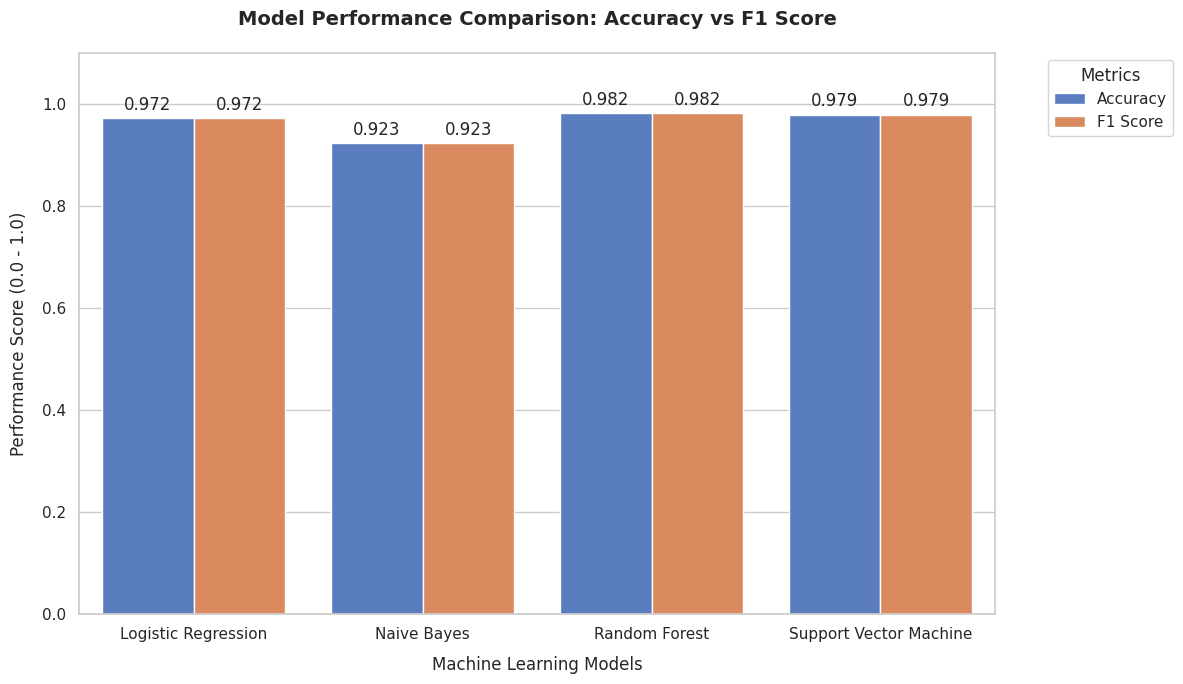

In [13]:
results_df_ml = pd.DataFrame(results).T
sns.set_theme(style="whitegrid", palette="muted")
plot_data = results_df_ml[['Accuracy', 'F1 Score']].reset_index().melt(id_vars='index')
plot_data.columns = ['Model', 'Metric', 'Score']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=plot_data, x='Model', y='Score', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)
plt.title("Model Performance Comparison: Accuracy vs F1 Score", fontsize=14, fontweight='bold', pad=20)
plt.ylabel("Performance Score (0.0 - 1.0)", fontsize=12, labelpad = 10)
plt.xlabel("Machine Learning Models", fontsize=12, labelpad = 10)
plt.ylim(0, 1.1)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Confusion Matrices**

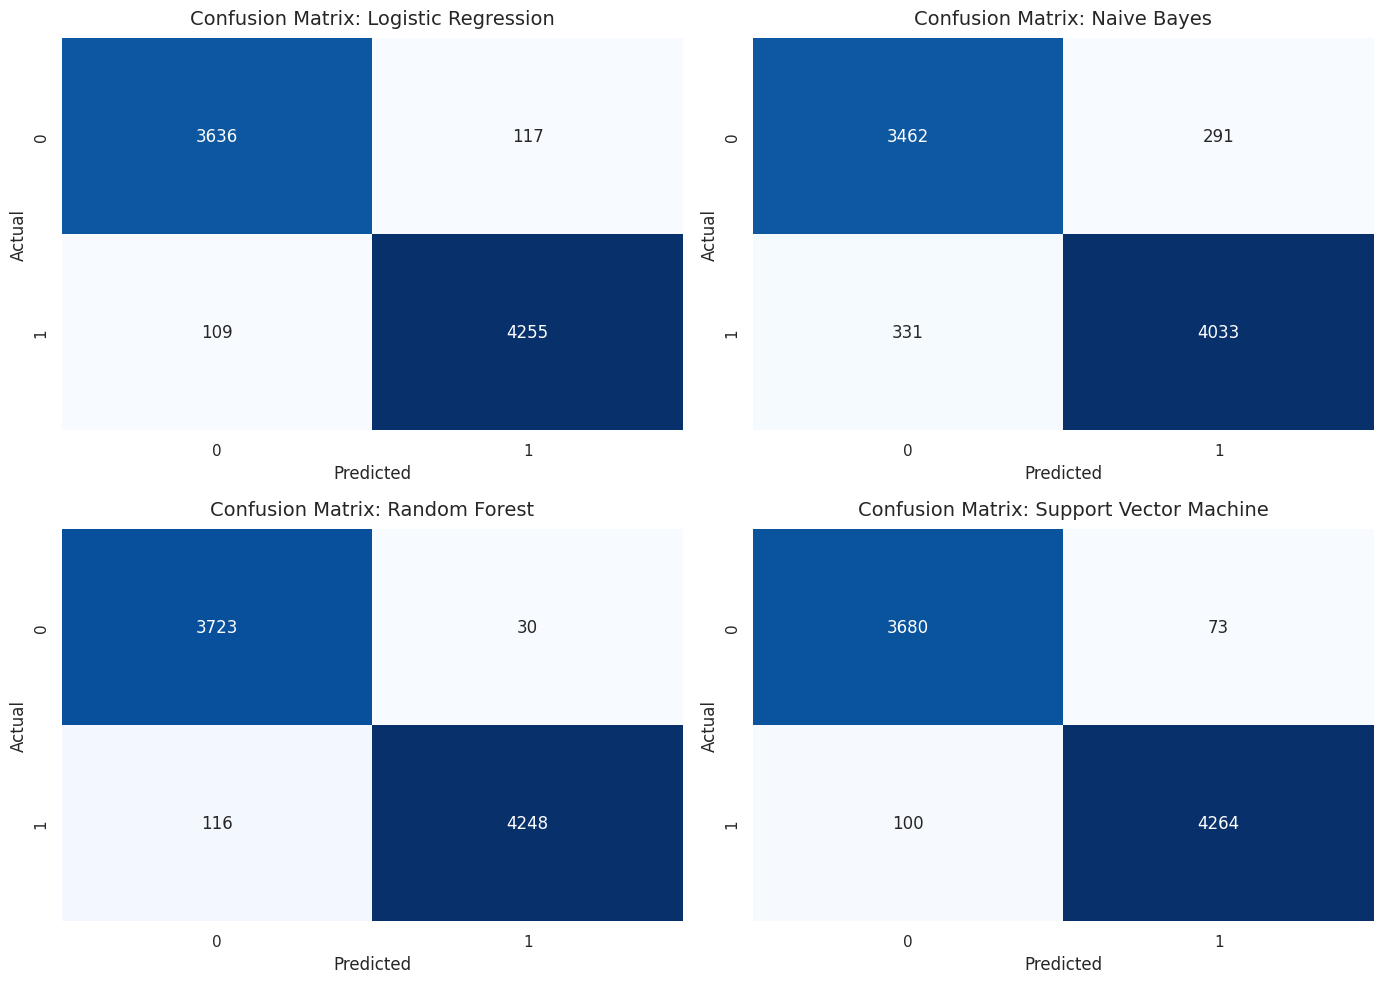

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(x_test_vec)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix: {name}", fontsize=14, pad = 10)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# **Applying BERT Model**

**Preprocessing**

In [20]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

**Tokenizer and BERT Model**

In [25]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Check for GPU and move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)
print(f"BERT model moved to: {device}")

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


**Generating Data Loaders**

In [26]:
train_dataset = NewsDataset(
    train_df['content'].to_numpy(),
    train_df['label'].to_numpy(),
    tokenizer
)
test_dataset = NewsDataset(
    test_df['content'].to_numpy(),
    test_df['label'].to_numpy(),
    tokenizer
)

**Training Arguments**

In [27]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=50,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy="epoch",
    report_to = "none"
)

**Trainer Setup**

In [28]:
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

print("\nStarting BERT Fine-Tuning")
trainer.train()


Starting BERT Fine-Tuning


Epoch,Training Loss,Validation Loss
1,0.166935,0.086120
2,0.063001,0.092953
3,0.122435,0.090631


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=9135, training_loss=0.11666026690222434, metrics={'train_runtime': 3015.692, 'train_samples_per_second': 24.226, 'train_steps_per_second': 3.029, 'total_flos': 4805657648386560.0, 'train_loss': 0.11666026690222434, 'epoch': 3.0})

--- Deep Learning (BERT) Results ---
Accuracy: 0.9820
Precision: 0.9965
Recall: 0.9700
F1 Score: 0.9830


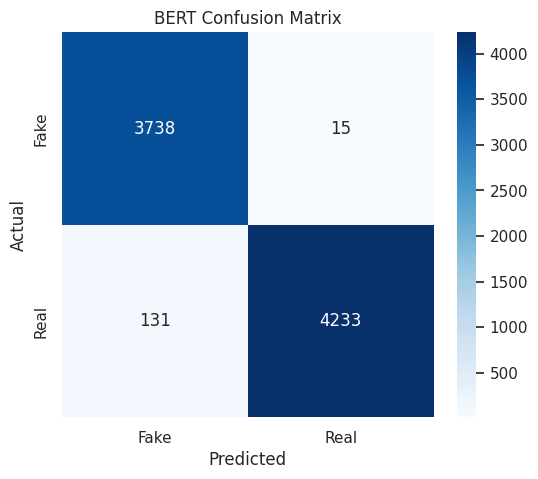

In [29]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

acc = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print("--- Deep Learning (BERT) Results ---")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

**Confusion Matrix**

In [ ]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('BERT Confusion Matrix')
plt.show()